In [82]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import pandas as pd

from arch import arch_model

plt.style.use('ggplot')

N = 3000   # Length of an MCMC simulation
B = 500    # Burn-ins for an MCMC simulation
N0 = 1500  # Length of a short MCMC simulation for questions 2 and 3
B0 = 300   # Burn-ins for a short MCMC simulation for questions 2 and 3
s0 = 0.1   # Standard deviation of the normal law for the random walk on the Metropolis algorithms for wO
s1 = 0.05  # Standard deviation of the normal law for the random walk on the Metropolis algorithms for w1
s2 = 0.04  # Standard deviation of the normal law for the random walk on the Metropolis algorithms for w2

# QUESTION 1 : 

In this first part, we're going to implement a random walk Metropolis
sampler that targets the posterior distribution of a GARCH model. First using generated data then using log-returns from real exchange rates data.  


Throughout the project we will be considering a GARCH(1,1) model as follows : 

$r_{t} = \epsilon_{t} \sqrt{h_{t}}$

with  $h_{t} = w_{0} + w_{1} r_{t-1}^2 + w_{2} h_{t-1}$

And $w_{0}>0, w_{1}>0, w_{2} >0$

As the paper suggests, we consider a Normal-GARCH model such that $r_{t}|F_{t-1}$, follows a normal distribution $\mathcal{N} (0,h_{t})$ and so $\epsilon_{t}$ follows a normal distribution $\mathcal{N} (0,1)$

## Using Generated Data

We start by generating our GARCH(1,1) data.

In [80]:
# GARCH(1, 1) parameters
w = np.array([1, 0.7, 0.2])
# Length of the GARCH simulation
n =1000


In [24]:
def garch(w, n):
    r = np.zeros(n)
    r[0] = np.random.randn()
    e = np.random.randn(n)
    h = np.zeros(n)
    h[0] = np.random.randn()
    for i in range(n-1):
        h[i+1] = w[0] + w[1] * r[i] * r[i] + w[2] * h[i]
        r[i+1] = e[i+1] * np.sqrt(h[i+1])
    return r

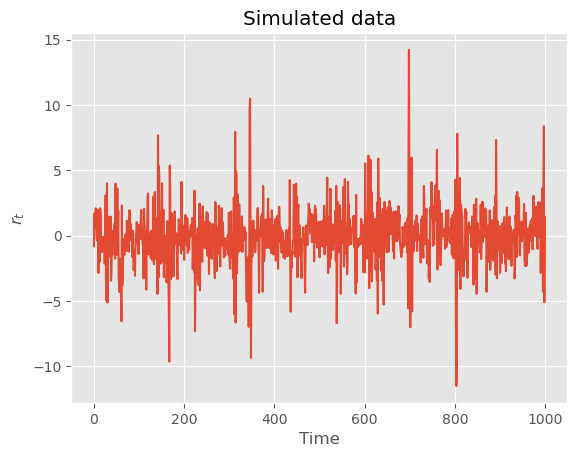

In [25]:
r = garch(w, n)

plt.plot(range(n), r)
plt.title('Simulated data')
plt.xlabel('Time')
plt.ylabel('$r_{t} $')
plt.show()

Now, we will be fitting a GARCH(1,1) model to our generated data, to check if our generation process is accurate.  

In [26]:
# by default the arch_model function assumes a GARCH(1,1) model
m = arch_model(r)
R = m.fit(update_freq=10)
print(R.summary())

Iteration:     10,   Func. Count:     59,   Neg. LLF: 2038.8816144621617
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2038.8428915769694
            Iterations: 13
            Function evaluations: 74
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2038.84
Distribution:                  Normal   AIC:                           4085.69
Method:            Maximum Likelihood   BIC:                           4105.32
                                        No. Observations:                 1000
Date:                Sun, Apr 28 2024   Df Residuals:                      999
Time:                        20:03:54   Df Model:                            1
      

As we can see this gives us approximately the exact parameters and distribution of the GARCH that we used for our data generation, which shows that our generation process is reliable.

### Metropolis for the generated data

We will be working in a Bayesian framework, our goal is to estimate the posterior distribution $ \pi(w|r) $ using a random walk Metropolis algorithm.

Specifically, we are interested in estimating the expected value of $ \omega_j $ under the posterior distribution $ \pi(\omega_j|r) $. We assume that the prior distribution follows a normal distribution $\mathcal{N} (0,1)$, but since the parameters $ w_j $ are constrained to be greater than 0, we need to consider truncated normal priors.

$ \pi(\omega_j | r) \propto \pi(r | \omega_j) \times \pi(\omega_j) $

Where:
- $ \pi(r | \omega_j) $ is the likelihood function, representing the probability of observing the data $ r $ given the parameters $ \omega_j $.
- $ \pi(\omega_j) $ is the prior distribution.

Note that :  

$\frac{\pi(W|r)}{\pi(w|r)} $ = $\exp \left( -\frac{1}{2} \left[ \sum_{t=1}^{T} \left( \ln \left( \frac{H_t}{h_t} \right) + r_t^2 \left( \frac{1}{H_t} - \frac{1}{h_t} \right) \right) + W^2 - w^2 \right] \right)$



In [81]:
# Extracting the conditional volatility sequence from a garch model r
def sigmas(w, r):
    T = len(r)
    h = np.zeros(T)
    h[0] = np.random.random()
    for t in range(1, T):
        h[t] = w[0] + w[1] * r[t-1] * r[t-1] + w[2] * h[t-1]
    return h

b = 50 # Burn-ins for the GARCH simulation for the "proba" function in order to ignore the first uncertain conditional variances

# Acceptance probability for parameter w_j with a burn-in period b
def proba(w, W, r, b, j):
    T = len(r)
    h = sigmas(w, r)
    H = sigmas(W, r)
    S = 0
    S = sum(r[t] * r[t] * (1/H[t] - 1/h[t]) + np.log(H[t]) - np.log(h[t]) for t in range(b, T))
    if - (W[j] ** 2 - w[j] ** 2) / 2 - S / 2 > 1:
        return 1
    return np.exp(- (W[j] ** 2 - w[j] ** 2) / 2 - S / 2)

We use the following proposal distribution for our algorithm:

$ q(W|w)$ ~ $\mathcal{N} (w,s)$ 
where $s$ takes $s_{0}$, $s_{1}$ and $s_{2}$ respectively for the parameters $w_{0}$, $w_{1}$ and $w_{2}$

In addition the GARCH(1,1) model has a second-order and causal solution iff $ w_{1} +w_{2} < 1 $ 

In [83]:
def algo_RWMHwG(N, r, B, b):
    w = np.random.random(3) / 3
    W = np.copy(w)

    # Counters for the acceptance rates
    c0 = 0
    c1 = 0
    c2 = 0

    # Uniform laws to compare to the rejection probability on each step
    u0 = np.random.random(N)
    u1 = np.random.random(N)
    u2 = np.random.random(N)

    # Proposed steps to sample according to the proposal distribution q
    v0 = np.random.randn(N) * s0
    v1 = np.random.randn(N) * s1
    v2 = np.random.randn(N) * s2
    
    # To store the trajectories of the parameters
    w0 = np.zeros(N+1)
    w1 = np.zeros(N+1)
    w2 = np.zeros(N+1)

    # Initialization
    w0[0] = w[0]
    w1[0] = w[1]
    w2[0] = w[2]

    # Main loop
    for i in range(N):
        if i%1000 == 0:
            print(str(i) + ' loops completed')
        
        W[0] += v0[i]
        if W[0] > 0:
            R = proba(w, W, r, b, 0)
            if R > u0[i]:
                w[0] += v0[i]
                c0 += 1
            else:
                W[0] -= v0[i]
        else:
            W[0] -= v0[i]
        w0[i+1] = w[0]

        W[1] += v1[i]
        if W[1] > 0 and W[1] + W[2] < 1:
            R = proba(w, W, r, b, 1)
            if R > u1[i]:
                w[1] += v1[i]
                c1 += 1
            else:
                W[1] -= v1[i]
        else:
            W[1] -= v1[i]
        w1[i+1] = w[1]

        W[2] += v2[i]
        if W[2] > 0 and W[1] + W[2] < 1:
            R = proba(w, W, r, b, 2)
            if R > u2[i]:
                w[2] += v2[i]
                c2 += 1
            else:
                W[2] -= v2[i]
        else:
            W[2] -= v2[i]
        w2[i+1] = w[2]

    c0 /= N
    c1 /= N
    c2 /= N
    
    # Empirical means
    RA0 = np.sum(w0[B:]) / (N - B + 1)
    RA1 = np.sum(w1[B:]) / (N - B + 1)
    RA2 = np.sum(w2[B:]) / (N - B + 1)

    # Empirical variances
    RV0 = np.sum(w0[B:] ** 2) / (N - B + 1) - RA0 ** 2
    RV1 = np.sum(w1[B:] ** 2) / (N - B + 1) - RA1 ** 2
    RV2 = np.sum(w2[B:] ** 2) / (N - B + 1) - RA2 ** 2

    return [RA0, RA1, RA2], [RV0, RV1, RV2], [c0, c1, c2], w0, w1, w2

In [29]:
U = algo_RWMHwG(N, r, B, b)

0 loops completed
1000 loops completed
2000 loops completed


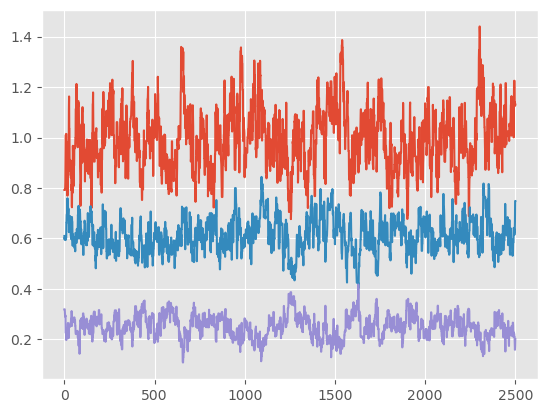

In [30]:
plt.plot(range(N-B+1), U[-3][B:])
plt.plot(range(N-B+1), U[-2][B:])
plt.plot(range(N-B+1), U[-1][B:])

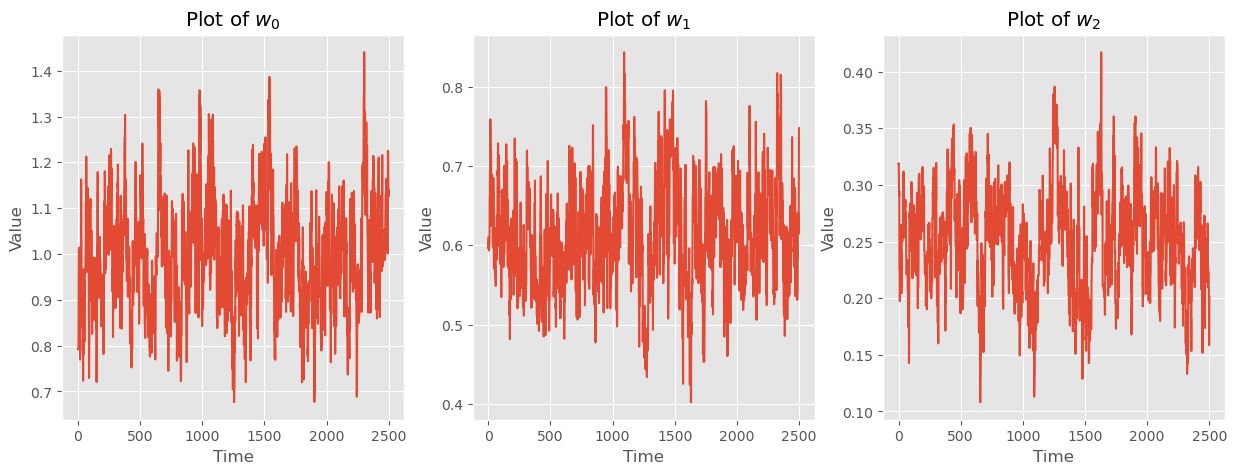

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(range(N-B+1), U[-3][B:])
axs[0].set_title('Plot of $w_{0}$')

axs[1].plot(range(N-B+1), U[-2][B:])
axs[1].set_title('Plot of $w_{1}$')

axs[2].plot(range(N-B+1), U[-1][B:])
axs[2].set_title('Plot of $w_{2}$')

for ax in axs:
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")

plt.show()

In [41]:
print(f"for w0 The acceptance rate is :{U[2][0]}  The empirical mean is : {U[0][0]} The empirical variance is : {U[1][0]}" )
print(f"for w1 The acceptance rate is :{U[2][1]}  The empirical mean is : {U[0][1]} The empirical variance is : {U[1][1]}" )
print(f"for w2 The acceptance rate is :{U[2][2]}  The empirical mean is : {U[0][2]} The empirical variance is : {U[1][2]}" )

for w0 The acceptance rate is :0.6583333333333333  The empirical mean is : 0.993962608944134 The empirical variance is : 0.01456915567818351
for w1 The acceptance rate is :0.678  The empirical mean is : 0.613259525637046 The empirical variance is : 0.004501200263373806
for w2 The acceptance rate is :0.5573333333333333  The empirical mean is : 0.25138779837995107 The empirical variance is : 0.002082011573493428


## Metropolis for real data

Now we will be working with log-return computed from real exchange rates data. We have chosen to use EUR/USD exchange rates from January 1, 2004, to April 1, 2024, which we obtained from Yahoo Finance.

In [34]:
data = pd.read_csv("EURUSD.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-01-01,1.259002,1.260796,1.247396,1.258194,1.258194,0.0
1,2004-01-02,1.258194,1.262802,1.252693,1.258194,1.258194,0.0
2,2004-01-05,1.263903,1.269406,1.263695,1.268698,1.268698,0.0
3,2004-01-06,1.268907,1.280803,1.267202,1.272103,1.272103,0.0
4,2004-01-07,1.272394,1.273999,1.262499,1.264095,1.264095,0.0


In [35]:
# Calculate log-returns
data['Log_Return'] = np.log(data['Close']).diff()

# Drop NaN values resulting from the differencing operation
data.dropna(inplace=True)

# Print first few rows of the dataset with log-returns
print(data.head())

         Date      Open      High       Low     Close  Adj Close  Volume  \
1  2004-01-02  1.258194  1.262802  1.252693  1.258194   1.258194     0.0   
2  2004-01-05  1.263903  1.269406  1.263695  1.268698   1.268698     0.0   
3  2004-01-06  1.268907  1.280803  1.267202  1.272103   1.272103     0.0   
4  2004-01-07  1.272394  1.273999  1.262499  1.264095   1.264095     0.0   
5  2004-01-08  1.264095  1.278707  1.256502  1.277498   1.277498     0.0   

   Log_Return  
1    0.000000  
2    0.008314  
3    0.002680  
4   -0.006315  
5    0.010547  


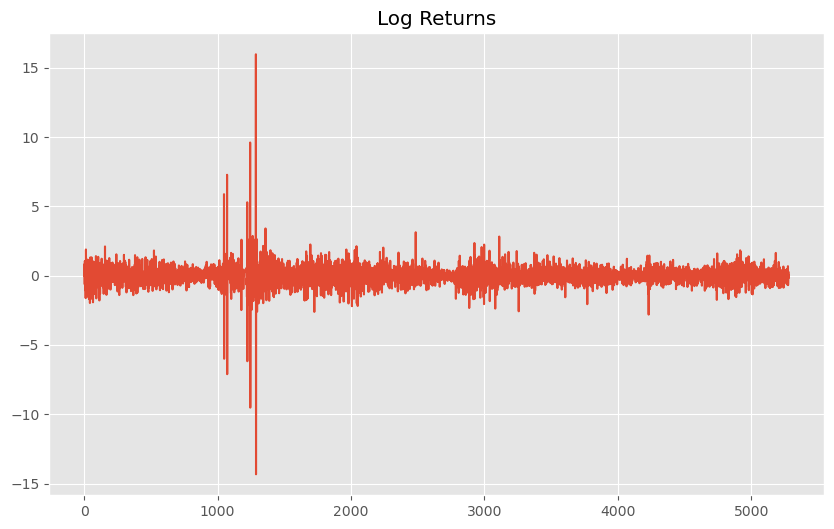

In [36]:
data['Log_Return'] = data['Log_Return'] * 100 # multiply by 100 to get in percentage because the values are close to 0

# Plot log returns
plt.figure(figsize=(10,6))
plt.plot(data['Log_Return'])
plt.title('Log Returns')
plt.show()

In [37]:
R = algo_RWMHwG(N, r, B, b)

0 loops completed
1000 loops completed
2000 loops completed


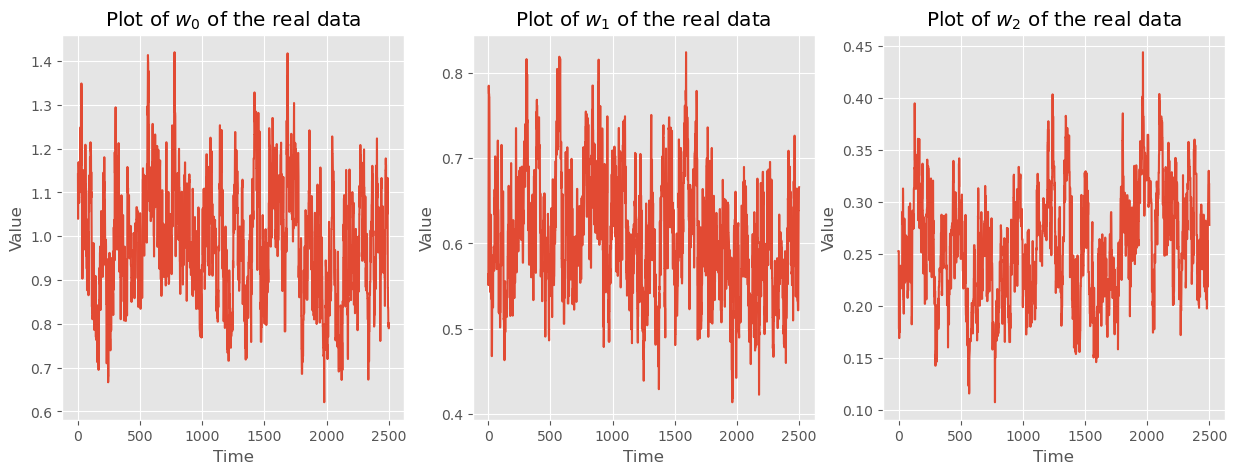

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(range(N-B+1), R[-3][B:])
axs[0].set_title('Plot of $w_{0}$ of the real data')

axs[1].plot(range(N-B+1), R[-2][B:])
axs[1].set_title('Plot of $w_{1}$ of the real data')

axs[2].plot(range(N-B+1), R[-1][B:])
axs[2].set_title('Plot of $w_{2}$ of the real data')

for ax in axs:
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")

plt.show()

In [42]:
print(f"for w0 The acceptance rate is :{R[2][0]}  The empirical mean is : {R[0][0]} The empirical variance is : {R[1][0]}" )
print(f"for w1 The acceptance rate is :{R[2][1]}  The empirical mean is : {R[0][1]} The empirical variance is : {R[1][1]}" )
print(f"for w2 The acceptance rate is :{R[2][2]}  The empirical mean is : {R[0][2]} The empirical variance is : {R[1][2]}" )

for w0 The acceptance rate is :0.654  The empirical mean is : 0.9844723417921587 The empirical variance is : 0.018128241340465978
for w1 The acceptance rate is :0.681  The empirical mean is : 0.6081820573124619 The empirical variance is : 0.005037061066774096
for w2 The acceptance rate is :0.57  The empirical mean is : 0.2567742568029968 The empirical variance is : 0.0028008373068256626


# QUESTION 2

The aim of this question is to use controle variates in order to reduce the variance of our estimators.

Let H be the Schrödinger-type Hamiltonian operator defined below:

$Hf = -\frac{1}{2}\sum_{i=0}^{2}\frac{\partial }{\partial \omega_i}f + V(\omega_0, \omega_1, \omega_2)f$  $\quad$  where: $\quad$ $V(\omega_0, \omega_1, \omega_2) = \frac{1}{2\sqrt{\pi(\omega_0, \omega_1, \omega_2\mid(r_{t}))}}\Delta\pi(\omega_0, \omega_1, \omega_2\mid(r_{t}))$

Also let $\Psi$ be an infinitely differentiable trial function with compact support. We assume, as Antonietta Mira does in the article, that this condition holds: $H\sqrt{\pi(\omega_0, \omega_1, \omega_2\mid(r_{t}))}$ = 0

Then, the re-normalized function defined as: $f_i({\omega_0, \omega_1, \omega_2}) = \omega_i +\frac{H\Psi(\omega_0, \omega_1, \omega_2)}{\sqrt{\pi(\omega_0, \omega_1, \omega_2\mid(r_{t}))}}$

has the same expected value as $\omega_i$, but might have a reduced variance.

We choose the following trial function: $\Psi(\omega_0, \omega_1, \omega_2) = P(\omega_0, \omega_1, \omega_2)\sqrt{\pi(\omega_0, \omega_1, \omega_2\mid(r_{t}))}$ $\quad$ where P is a polynomial function.

Then, the re-normalized function is : $f_i({\omega_0, \omega_1, \omega_2}) = \omega_i-\frac{1}{2}\Delta P(\omega_0, \omega_1, \omega_2) + \nabla P(\omega_0, \omega_1, \omega_2) \cdot z$ $\quad$ 

where: 

$z = -\frac{1}{2}\nabla ln(\pi(\omega_0, \omega_1, \omega_2\mid(r_{t})))$ 

$\Delta = \frac{\partial^2 }{\partial^2 \omega_0} + \frac{\partial^2 }{\partial^2 \omega_1} + \frac{\partial^2 }{\partial^2 \omega_2}$ (Laplacian Operator)

$\nabla = (\frac{\partial }{\partial \omega_0}, \frac{\partial }{\partial \omega_1}, \frac{\partial }{\partial \omega_2})$ (Gradient)

Here, we have: $\frac{\partial ln(\pi(\omega_0, \omega_1, \omega_2\mid(r_{t})))}{\partial \omega_i} = - \omega_i -\frac{1}{2}\sum_{t=1}^{T}\frac{\partial h_t}{\partial \omega_i}[\frac{1}{h_t} - \frac{r_t^2}{h_t^2}] $

The function z_CV below computes the vector $z = -\frac{1}{2}\nabla ln(\pi(\omega_0, \omega_1, \omega_2\mid(r_{t})))$

In [44]:
def z_CV(w, r):
    T = len(r)
    h = sigmas(w, r)
    
    dh0 = np.zeros(T)
    dh1 = np.zeros(T)
    dh2 = np.zeros(T)
    
    for t in range(1, T):
        dh0[t] = 1 + w[2] * dh0[t-1]
        dh1[t] = r[t-1] * r[t-1] + w[2] * dh1[t-1]
        dh2[t] = h[t-1] + w[2] * dh1[t-1]
        
    S0 = 0
    S1 = 0
    S2 = 0
    
    for t in range(1, T):
        S0 += dh0[t] * (1 / h[t] - (r[t] / h[t]) ** 2)
        S1 += dh1[t] * (1 / h[t] - (r[t] / h[t]) ** 2)
        S2 += dh2[t] * (1 / h[t] - (r[t] / h[t]) ** 2)
        
    return np.array([(w[0] + S0 / 2) / 2, (w[1] + S1 / 2) / 2, (w[2] + S2 / 2) / 2])

In this question, we consider a 1st degree polynomial $P(x) = a^Tx$. Then, the re-normalized function is: $f_i({\omega_0, \omega_1, \omega_2}) = \omega_i - a_i^Tz$

and the optimal vector $a_i$, which minimizes the variance of $f_i$, is: $a_i = - E[zz^T]E[z\omega_i]$ for all i=0,1,2

$a_i$ can be estimated by running an OLS regression of $\omega_i$ on z: the estimator of $a_i$ will be the opposite of the OLS estimator (excluding the constant).

In practice, we use a 2-steps method :

- First, we run a short MCMC simulation in order to obtain samples of $(\omega_0, \omega_1, \omega_2)$, and we do 3 OLS regression of each $\omega_i$ on z in order to determine $a_0, a_1$ and $a_2$

- Then, we run a long MCMC simulation where we consider the sequences of $f_0, f_1$ and $f_2$ instead of $\omega_0, \omega_1$, and $\omega_2$.

The function a_CV runs the short MCMC simulation in order to obtain our 3 vectors $a_0, a_1$ and $a_2$. The algo_RWMHwG_CV runs the long MCMC after determining $a_0, a_1$ and $a_2$, so it runs the whole process.

In [78]:
def a_CV(r, N0, B0, b):
    U = algo_RWMHwG(N0, r, B0, b)

    # Store the samples in each array
    w0 = np.copy(U[-3][B0:])
    w1 = np.copy(U[-2][B0:])
    w2 = np.copy(U[-1][B0:])

    # Create the vectors z for the OLS regressions
    Z = np.zeros((N0 - B0 + 1, 3))
    for i in range(N0 - B0 + 1):
        Z[i] = z_CV([w0[i], w1[i], w2[i]], r)
    Z = sm.add_constant(Z)

    # Regression for each parameter
    M0 = sm.OLS(w0, Z)
    M1 = sm.OLS(w1, Z)
    M2 = sm.OLS(w2, Z)
    
    R0 = M0.fit()
    R1 = M1.fit()
    R2 = M2.fit()
    
    return - np.array(R0.params[1:]), - np.array(R1.params[1:]), - np.array(R2.params[1:])


def f_CV(w, r, a):
    z = z_CV(w, r)
    return w + np.dot(z, a)


def algo_RWMHwG_CV(N, r, B, b, N0, B0):
    a0, a1, a2 = a_CV(r, N0, B0, b) # The short MCMC simulation
    
    w = np.random.random(3) / 3
    W = np.copy(w)
    
    c0 = 0
    c1 = 0
    c2 = 0
    
    u0 = np.random.random(N)
    u1 = np.random.random(N)
    u2 = np.random.random(N)
    
    v0 = np.random.randn(N) * s0
    v1 = np.random.randn(N) * s1
    v2 = np.random.randn(N) * s2
    
    w0 = np.zeros(N+1)
    w1 = np.zeros(N+1)
    w2 = np.zeros(N+1)
    
    w0[0] = w[0]
    w1[0] = w[1]
    w2[0] = w[2]
    
    for i in range(N):
        if i%1000 == 0:
            print(str(i) + ' loops completed')
        
        W[0] += v0[i]
        if W[0] > 0:
            R = proba(w, W, r, b, 0)
            if R > u0[i]:
                w[0] += v0[i]
                c0 += 1
            else:
                W[0] -= v0[i]
        else:
            W[0] -= v0[i]
        w0[i+1] = f_CV(w, r, a0)[0] # We keep f_0

        W[1] += v1[i]
        if W[1] > 0 and W[1] + W[2] < 1:
            R = proba(w, W, r, b, 1)
            if R > u1[i]:
                w[1] += v1[i]
                c1 += 1
            else:
                W[1] -= v1[i]
        else:
            W[1] -= v1[i]
        w1[i+1] = f_CV(w, r, a1)[1] # We keep f_1

        W[2] += v2[i]
        if W[2] > 0 and W[1] + W[2] < 1:
            R = proba(w, W, r, b, 2)
            if R > u2[i]:
                w[2] += v2[i]
                c2 += 1
            else:
                W[2] -= v2[i]
        else:
            W[2] -= v2[i]
        w2[i+1] = f_CV(w, r, a2)[2] # We keep f_2

    c0 /= N
    c1 /= N
    c2 /= N
    
    RA0 = np.sum(w0[B:]) / (N - B + 1)
    RA1 = np.sum(w1[B:]) / (N - B + 1)
    RA2 = np.sum(w2[B:]) / (N - B + 1)
    
    RV0 = np.sum(w0[B:] ** 2) / (N - B + 1) - RA0 ** 2
    RV1 = np.sum(w1[B:] ** 2) / (N - B + 1) - RA1 ** 2
    RV2 = np.sum(w2[B:] ** 2) / (N - B + 1) - RA2 ** 2

    return [RA0, RA1, RA2], [RV0, RV1, RV2], [c0, c1, c2], w0, w1, w2

In [46]:
V = algo_RWMHwG_CV(N, r, B, b, N0, B0)

0 loops completed
1000 loops completed
0 loops completed
1000 loops completed
2000 loops completed


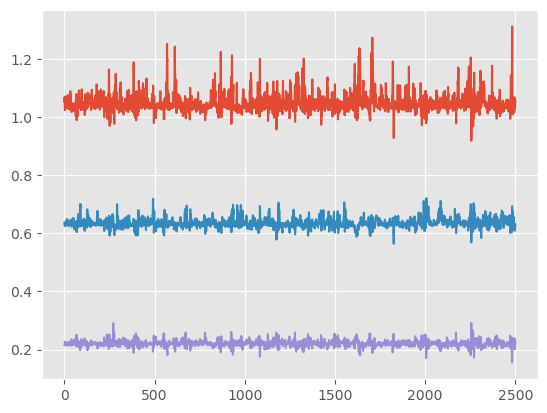

In [47]:
plt.plot(range(N-B+1), V[-3][B:])
plt.plot(range(N-B+1), V[-2][B:])
plt.plot(range(N-B+1), V[-1][B:])

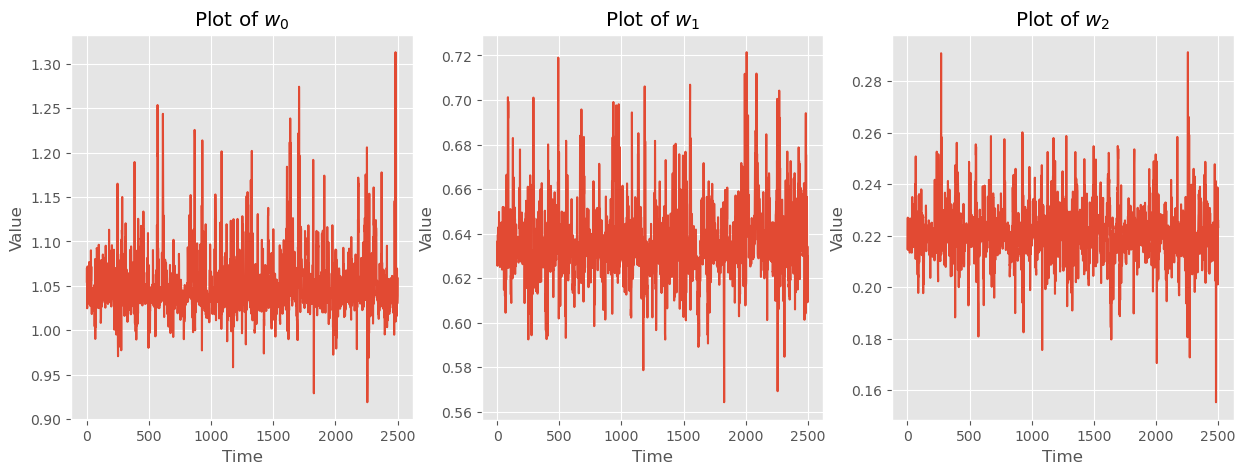

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(range(N-B+1), V[-3][B:])
axs[0].set_title('Plot of $w_{0}$')

axs[1].plot(range(N-B+1), V[-2][B:])
axs[1].set_title('Plot of $w_{1}$')

axs[2].plot(range(N-B+1), V[-1][B:])
axs[2].set_title('Plot of $w_{2}$')

for ax in axs:
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")

plt.show()

In [49]:
print(f"for w0  The acceptance rate is :{V[2][0]}  The empirical mean is : {V[0][0]} The empirical variance is : {V[1][0]}" )
print(f"for w1  The acceptance rate is :{V[2][1]}  The empirical mean is : {V[0][1]} The empirical variance is : {V[1][1]}" )
print(f"for w2  The acceptance rate is :{V[2][2]}  The empirical mean is : {V[0][2]} The empirical variance is : {V[1][2]}" )

for w0  The acceptance rate is :0.628  The empirical mean is : 1.048993391806644 The empirical variance is : 0.0011501365018671272
for w1  The acceptance rate is :0.677  The empirical mean is : 0.6351072576423287 The empirical variance is : 0.0002650835324356504
for w2  The acceptance rate is :0.5573333333333333  The empirical mean is : 0.2214681507286543 The empirical variance is : 0.00010900877725654456


## Comparaison with Q1

In [51]:
print(f"the empirical variance for w0 after using control variates is {U[1][0] / V[1][0]} times smaller")
print(f"the empirical variance for w1 after using control variates is {U[1][1] / V[1][1]} times smaller")
print(f"the empirical variance for w2 after using control variates is {U[1][2] / V[1][2]} times smaller")

the empirical variance for w0 after using control variates is 12.667327447248216 times smaller
the empirical variance for w1 after using control variates is 16.980308893637073 times smaller
the empirical variance for w2 after using control variates is 19.09948561842464 times smaller


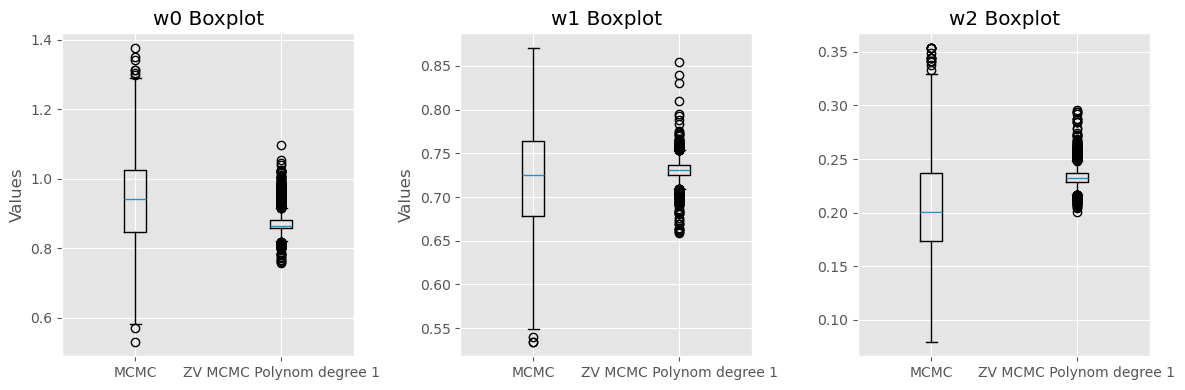

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# w_0 box-plot
axes[0].boxplot([U[-3][B:], V[-3][B:]])
axes[0].set_xticklabels(['MCMC', 'ZV MCMC Polynom degree 1'])
axes[0].set_ylabel('Values')
axes[0].set_title('w0 Boxplot')

# w_1 box-plot
axes[1].boxplot([U[-2][B:], V[-2][B:]])
axes[1].set_xticklabels(['MCMC', 'ZV MCMC Polynom degree 1'])
axes[1].set_ylabel('Values')
axes[1].set_title('w1 Boxplot')

# w_2 box-plot
axes[2].boxplot([U[-1][B:], V[-1][B:]])
axes[2].set_xticklabels(['MCMC', 'ZV MCMC Polynom degree 1'])
axes[2].set_title('w2 Boxplot')

fig.tight_layout()
plt.show()

We obtain similar results to the ones in Antonietta Mira's Paper.

# QUESTION 3

We consider this time a second degree polynomial function $P(x) = a^Tx + \frac{1}{2}x^TBx$. $\quad$ The re-normalized function becomes: $f_i({\omega_0, \omega_1, \omega_2}) = \omega_i - \frac{1}{2}tr(B) + (a+Bx)^Tz$ $\quad$ where x = $({\omega_0, \omega_1, \omega_2})^T$

This means we have to consider 12 potential control variates : 

$z_0, \quad \quad z_1, \quad \quad z_2$,

$z_0\omega_0, \quad z_1\omega_0, \quad z_2\omega_0$,

$z_0\omega_1, \quad z_1\omega_1, \quad z_2\omega_1$,

$z_0\omega_2, \quad z_1\omega_2, \quad z_2\omega_2$

The computational complexity of an OLS regression being O($d^2N$), an OLS regression on too many control variates would be costly.

We implement 2 methods in order to select 3 control variates among these 12.

First, these are 2 small functions which will help later.

In [84]:
def Support(T):
    t = 0
    for k in range(len(T)):
        if T[k] != 0:
            t += 1
    return t

def translate(y0, y1, y2):
    # This function takes the arrays which tell which control variates have been selected, and "translate" it for the reader
    # for exemple, 0 being an element of y1 means that z0 was kept as a control variate for w1.
    x = ["z0", "z1", "z2", "w0 * z0", "w1 * z1", "w2 * z2", "w0 * z1", "w1 * z2", "w2 * z0", "w0 * z2", "w1 * z0", "w2 * z1"]
    X0 = []
    X1 = []
    X2 = []
    
    for k in range(12):
        if k in y0:
            X0.append(x[k])
        if k in y1:
            X1.append(x[k])
        if k in y2:
            X2.append(x[k])
            
    print("The selected control variates for w0 are "+X0[0]+", "+X0[1]+" and "+X0[2])
    print("The selected control variates for w1 are "+X1[0]+", "+X1[1]+" and "+X1[2])
    print("The selected control variates for w2 are "+X2[0]+", "+X2[1]+" and "+X2[2])

We also adapt z_CV into z_CVL so the function directly returns the 12 potential control variates.

In [53]:
def z_CVL(w, r):
    T = len(r)
    h = sigmas(w, r)
    
    dh0 = np.zeros(T)
    dh1 = np.zeros(T)
    dh2 = np.zeros(T)
    
    for t in range(1, T):
        dh0[t] = 1 + w[2] * dh0[t-1]
        dh1[t] = r[t-1] * r[t-1] + w[2] * dh1[t-1]
        dh2[t] = h[t-1] + w[2] * dh1[t-1]
        
    S0 = 0
    S1 = 0
    S2 = 0
    
    for t in range(1, T):
        S0 += dh0[t] * (1 / h[t] - (r[t] / h[t]) ** 2)
        S1 += dh1[t] * (1 / h[t] - (r[t] / h[t]) ** 2)
        S2 += dh2[t] * (1 / h[t] - (r[t] / h[t]) ** 2)
        
    z0 = (w[0] + S0 / 2) / 2
    z1 = (w[1] + S1 / 2) / 2
    z2 = (w[2] + S2 / 2) / 2
    
    return np.array([z0, z1, z2, w[0] * z0, w[1] * z1, w[2] * z2, w[0] * z1, w[1] * z2, w[2] * z0, w[0] * z2, w[1] * z0, w[2] * z1])

## First selection method: dichotomic search using LASSO

The first selection method we implement relies on a dichotomic search using LASSO regressions:

- We do a first LASSO regression of $\omega_i$ on z using a penalization coefficient of µ.

- if we get strictly more than 3 coefficient that are not zero (not including the constant), we increase µ and do another LASSO regression.

- if we get strictly less than 3 coefficient that are not zero (not including the constant), we decrease µ and do another LASSO regression.

- We repeat until we end up with 3 coefficients that are not zero, and we select the control variates that correspond to these coefficients.

- We do one last non-LASSO OLS regression of $\omega_i$ on these 3 control variates to obtain $a_i$.

Beside this selection process, we use a similar, 2-steps method, to the last question, where we run a short MCMC simulation to select the control variates and obtain $a_0, a_1$ and $a_2$; and then a longer MCMC simulation with the re-normalized function.

In [86]:
def a_dicho_CVL(r, N0, B0, b):
    U = algo_RWMHwG(N0, r, B0, b)
    z = 12   # Number of control variates to consider

    # Store the samples in each array
    w0 = np.copy(U[-3][B0:])
    w1 = np.copy(U[-2][B0:])
    w2 = np.copy(U[-1][B0:])

    # Compute the vectors z for the regressions
    Z = np.zeros((N0 - B0 + 1, z))
    for i in range(N0 - B0 + 1):
        Z[i] = z_CVL([w0[i], w1[i], w2[i]], r)
    Z = sm.add_constant(Z)
    
    M0 = sm.OLS(w0, Z)
    M1 = sm.OLS(w1, Z)
    M2 = sm.OLS(w2, Z)
    
    µ = 7   # Penalization coefficient
    
    R0 = M0.fit_regularized(alpha=µ, L1_wt=1.0)
    R1 = M1.fit_regularized(alpha=µ, L1_wt=1.0)
    R2 = M2.fit_regularized(alpha=µ, L1_wt=1.0)

    # Number of coefficients of the LASSO regression which are not equal to zero, without including the constant
    n0 = Support(R0.params[1:])
    n1 = Support(R1.params[1:])
    n2 = Support(R2.params[1:])

    # Dichotomic search described above
    
    x = 0.8
    c = 0
    while n0 != 3:
        if n0 > 3:
            µ += x
        else:
            if µ - x > 0:
                µ -= x
            else:
                µ *= 0.5
        c += 1
        if c > 5:
            x *= 0.5
            c = 0
        M0 = sm.OLS(w0, Z)
        R0 = M0.fit_regularized(alpha=µ, L1_wt=1.0)
        n0 = Support(R0.params[1:])
    print("Selection of control variates for w0 done")
    
    µ = 7
    x = 0.8
    c = 0
    while n1 != 3:
        if n1 > 3:
            µ += x
        else:
            if µ - x > 0:
                µ -= x
            else:
                µ *= 0.5
        c += 1
        if c > 5:
            x *= 0.5
            c = 0
        M1 = sm.OLS(w1, Z)
        R1 = M1.fit_regularized(alpha=µ, L1_wt=1.0)
        n1 = Support(R1.params[1:])
    print("Selection of control variates for w1 done")
    
    µ = 7
    x = 0.8
    c = 0
    while n2 != 3:
        if n2 > 3:
            µ += x
        else:
            if µ - x > 0:
                µ -= x
            else:
                µ *= 0.5
        c += 1
        if c > 5:
            x *= 0.5
            c = 0
        M2 = sm.OLS(w2, Z)
        R2 = M2.fit_regularized(alpha=µ, L1_wt=1.0)
        n2 = Support(R2.params[1:])
    print("Selection of control variates for w2 done")

    # y0, y1 and y2 "store" the information of which control variates were selected
    
    y0 = []
    y1 = []
    y2 = []
    
    for i in range(1, z + 1):
        if R0.params[i] != 0:
            y0.append(i-1)
        if R1.params[i] != 0:
            y1.append(i-1)
        if R2.params[i] != 0:
            y2.append(i-1)

    # Last non-LASSO OLS regressions to get the vectors a0, a1 and a2
    
    X0 = np.zeros((N0 - B0 + 1, 3))    
    X0[:, 0] = np.copy(Z[:, y0[0] + 1])
    X0[:, 1] = np.copy(Z[:, y0[1] + 1])
    X0[:, 2] = np.copy(Z[:, y0[2] + 1])
    X0 = sm.add_constant(X0)
    
    X1 = np.zeros((N0 - B0 + 1, 3))
    X1[:, 0] = np.copy(Z[:, y1[0] + 1])
    X1[:, 1] = np.copy(Z[:, y1[1] + 1])
    X1[:, 2] = np.copy(Z[:, y1[2] + 1])
    X1 = sm.add_constant(X1)
    
    X2 = np.zeros((N0 - B0 + 1, 3))
    X2[:, 0] = np.copy(Z[:, y2[0] + 1])
    X2[:, 1] = np.copy(Z[:, y2[1] + 1])
    X2[:, 2] = np.copy(Z[:, y2[2] + 1])
    X2 = sm.add_constant(X2)
    
    P0 = sm.OLS(w0, X0)
    P1 = sm.OLS(w1, X1)
    P2 = sm.OLS(w2, X2)
    
    Q0 = P0.fit()
    Q1 = P1.fit()
    Q2 = P2.fit()
    
    translate(y0, y1, y2)
    return y0, - np.array(Q0.params[1:]), y1, - np.array(Q1.params[1:]), y2, - np.array(Q2.params[1:])


def f_CVL(w, r, a, y):
    z = z_CVL(w, r)
    t = []
    for x in y:
        t.append(z[x])
    return w + np.dot(t, a)


def algo_RWMHwG_dicho_CVL(N, r, B, b, N0, B0):
    A = a_dicho_CVL(r, N0, B0, b)
    y0, a0, y1, a1, y2, a2 = A[0], A[1], A[2], A[3], A[4], A[5]
    
    w = np.random.random(3) / 3
    W = np.copy(w)
    
    c0 = 0
    c1 = 0
    c2 = 0
    
    u0 = np.random.random(N)
    u1 = np.random.random(N)
    u2 = np.random.random(N)
    
    v0 = np.random.randn(N) * s0
    v1 = np.random.randn(N) * s1
    v2 = np.random.randn(N) * s2
    
    w0 = np.zeros(N+1)
    w1 = np.zeros(N+1)
    w2 = np.zeros(N+1)
    
    w0[0] = w[0]
    w1[0] = w[1]
    w2[0] = w[2]
    
    for i in range(N):
        if i%1000 == 0:
            print(str(i) + ' loops completed')
        
        W[0] += v0[i]
        if W[0] > 0:
            R = proba(w, W, r, b, 0)
            if R > u0[i]:
                w[0] += v0[i]
                c0 += 1
            else:
                W[0] -= v0[i]
        else:
            W[0] -= v0[i]
        w0[i+1] = f_CVL(w, r, a0, y0)[0]

        W[1] += v1[i]
        if W[1] > 0 and W[1] + W[2] < 1:
            R = proba(w, W, r, b, 1)
            if R > u1[i]:
                w[1] += v1[i]
                c1 += 1
            else:
                W[1] -= v1[i]
        else:
            W[1] -= v1[i]
        w1[i+1] = f_CVL(w, r, a1, y1)[1]

        W[2] += v2[i]
        if W[2] > 0 and W[1] + W[2] < 1:
            R = proba(w, W, r, b, 2)
            if R > u2[i]:
                w[2] += v2[i]
                c2 += 1
            else:
                W[2] -= v2[i]
        else:
            W[2] -= v2[i]
        w2[i+1] = f_CVL(w, r, a2, y2)[2]

    c0 /= N
    c1 /= N
    c2 /= N
    
    RA0 = np.sum(w0[B:]) / (N - B + 1)
    RA1 = np.sum(w1[B:]) / (N - B + 1)
    RA2 = np.sum(w2[B:]) / (N - B + 1)
    
    RV0 = np.sum(w0[B:] ** 2) / (N - B + 1) - RA0 ** 2
    RV1 = np.sum(w1[B:] ** 2) / (N - B + 1) - RA1 ** 2
    RV2 = np.sum(w2[B:] ** 2) / (N - B + 1) - RA2 ** 2

    return [RA0, RA1, RA2], [RV0, RV1, RV2], [c0, c1, c2], w0, w1, w2

In [55]:
W = algo_RWMHwG_dicho_CVL(N, r, B, b, N0, B0)

0 loops completed
1000 loops completed
Selection of control variates for w0 done
Selection of control variates for w1 done
Selection of control variates for w2 done
The selected control variates for w0 are z2, w0 * z0 and w0 * z1
The selected control variates for w1 are z0, z2 and w0 * z1
The selected control variates for w2 are z0, z2 and w0 * z1
0 loops completed
1000 loops completed
2000 loops completed


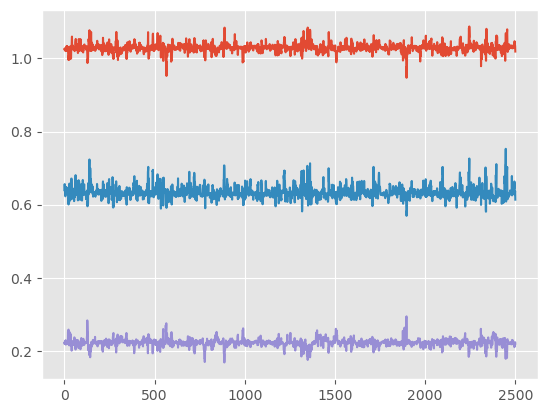

In [56]:
plt.plot(range(N-B+1), W[-3][B:])
plt.plot(range(N-B+1), W[-2][B:])
plt.plot(range(N-B+1), W[-1][B:])

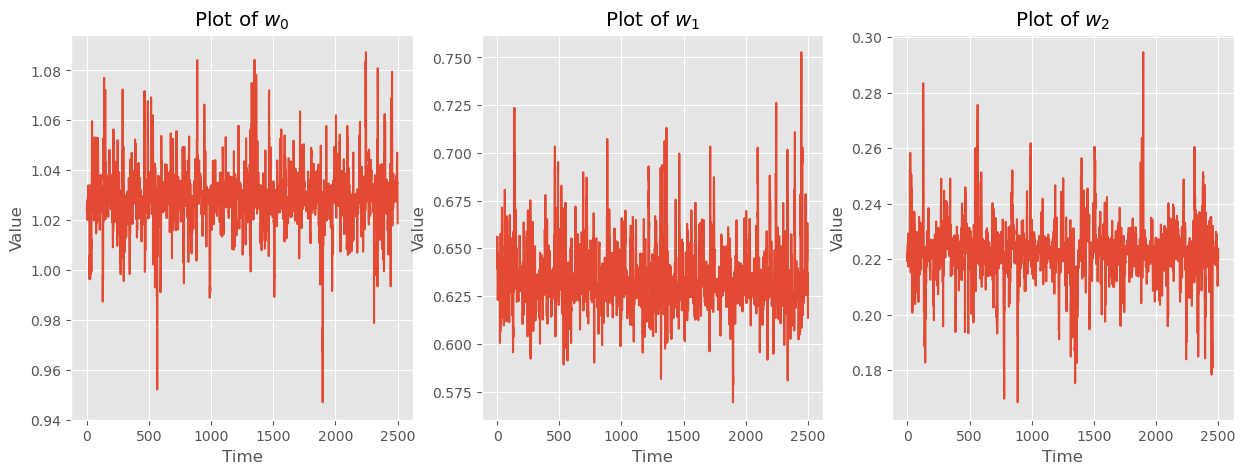

In [57]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(range(N-B+1), W[-3][B:])
axs[0].set_title('Plot of $w_{0}$')

axs[1].plot(range(N-B+1), W[-2][B:])
axs[1].set_title('Plot of $w_{1}$')

axs[2].plot(range(N-B+1), W[-1][B:])
axs[2].set_title('Plot of $w_{2}$')

for ax in axs:
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")

plt.show()

In [75]:
print(f"for w0 The acceptance rate is :{W[2][0]}  The empirical mean is : {W[0][0]} The empirical variance is : {W[1][0]}" )
print(f"for w1 The acceptance rate is :{W[2][1]}  The empirical mean is : {W[0][1]} The empirical variance is : {W[1][1]}" )
print(f"for w2 The acceptance rate is :{W[2][2]}  The empirical mean is : {W[0][2]} The empirical variance is : {W[1][2]}" )

for w0 The acceptance rate is :0.6463333333333333  The empirical mean is : 1.0290188791374317 The empirical variance is : 0.00013671819530070017
for w1 The acceptance rate is :0.6933333333333334  The empirical mean is : 0.6335441152018719 The empirical variance is : 0.00027962431415656797
for w2 The acceptance rate is :0.5503333333333333  The empirical mean is : 0.2228082952131392 The empirical variance is : 0.00011015165876012561


### Comparaison with Q1

In [59]:
print(f"the empirical variance for w0 after using control variates is {U[1][0] / W[1][0]} times smaller")
print(f"the empirical variance for w1 after using control variates is {U[1][1] / W[1][1]} times smaller")
print(f"the empirical variance for w2 after using control variates is {U[1][2] / W[1][2]} times smaller")

the empirical variance for w0 after using control variates is 106.56339959827496 times smaller
the empirical variance for w1 after using control variates is 16.097313557838472 times smaller
the empirical variance for w2 after using control variates is 18.901318390741352 times smaller


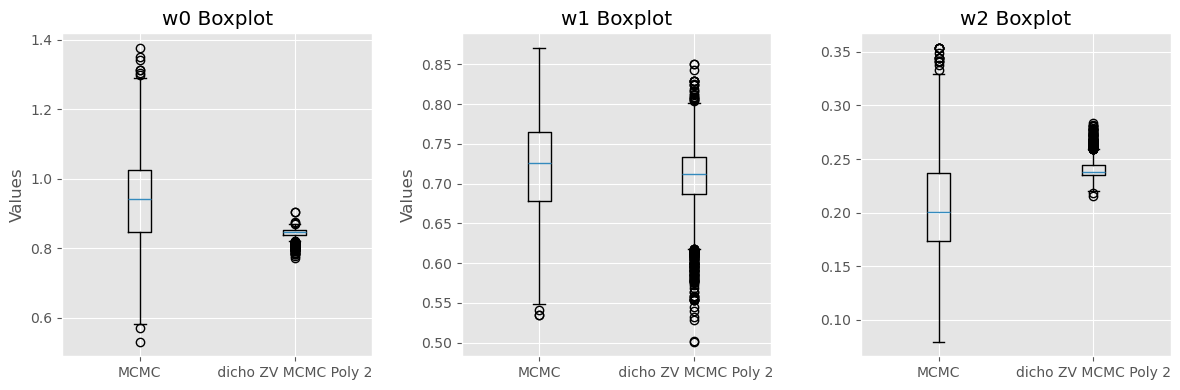

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# w_0 box-plot
axes[0].boxplot([U[-3][B:], W[-3][B:]])
axes[0].set_xticklabels(['MCMC', ' dicho ZV MCMC Poly 2 '])
axes[0].set_ylabel('Values')
axes[0].set_title('w0 Boxplot')

# w_1 box-plot
axes[1].boxplot([U[-2][B:], W[-2][B:]])
axes[1].set_xticklabels(['MCMC', ' dicho ZV MCMC Poly 2'])
axes[1].set_ylabel('Values')
axes[1].set_title('w1 Boxplot')

# w_2 box-plot
axes[2].boxplot([U[-1][B:], W[-1][B:]])
axes[2].set_xticklabels(['MCMC', 'dicho ZV MCMC Poly 2'])
axes[2].set_title('w2 Boxplot')

fig.tight_layout()
plt.show()

We obtain very inconsistent results with this method, which we are not sure why. This is why we have decided to implement the next method.

## Second selection method: selection on "intuitive" sets of triplets of potential control variates

For this method, we decide to consider all triplets of control variates, such that each $z_i$ appears once and only once. This means we consider $4^3$ = 64 possible triplets of control variates. We do this because it seemed that the regression on the second question worked fairly well, and it precisely uses the triplet ($z_0,z_1,z_2$).

For all i=0,1,2, we do a basic OLS regression of $\omega_i$ on each 64 triplets and keep the triplet of control variates that gets the better $R^2$ for its regression. We need to run 3 * 64 = 192 OLS regressions, which is reasonable, but this method would not be possible in larger dimensions. After selecting the right triplet, we can easily obtain the corresponding vector $a_i$, and proceed with the usual 2 steps method.

In [87]:
def a_64_CVL(r, N0, B0, b):
    U = algo_RWMHwG(N0, r, B0, b)
    z = 12
    m = z // 3

    # Store the samples in each array
    w0 = np.copy(U[-3][B0:])
    w1 = np.copy(U[-2][B0:])
    w2 = np.copy(U[-1][B0:])

    # Compute the control variates for the regressions
    Z = np.zeros((N0 - B0 + 1, z))
    for k in range(N0 - B0 + 1):
        Z[k] = z_CVL([w0[k], w1[k], w2[k]], r)

    # Create the 64 possible triplets of control variate to choose from
    x = np.zeros((m ** 3, 3), dtype=int)
    c = 0
    for i in range(m):
        for j in range(m):
            for k in range(m):
                x[c] = np.array([i * 3, 1 + j * 3, 2 + k * 3])
                x[c].sort()
                c += 1

    # Variables which will store the R^2 to compare them
    M0 = 0
    M1 = 0
    M2 = 0

    # Main loop for the 192 OLS regressions
    for p in range(m ** 3):
        
        X = np.zeros((N0 - B0 + 1, 3))
        X[:, 0] = np.copy(Z[:, x[p, 0]])
        X[:, 1] = np.copy(Z[:, x[p, 1]])
        X[:, 2] = np.copy(Z[:, x[p, 2]])
        X = sm.add_constant(X)
        
        Q0 = sm.OLS(w0, X)
        Q1 = sm.OLS(w1, X)
        Q2 = sm.OLS(w2, X)
        
        R0 = Q0.fit()
        R1 = Q1.fit()
        R2 = Q2.fit()
        
        r0 = R0.rsquared
        r1 = R1.rsquared
        r2 = R2.rsquared
        
        if r0 > M0:
            y0 = np.copy(x[p])
            a0 = - np.array(R0.params[1:])
            M0 = r0
            
        if r1 > M1:
            y1 = np.copy(x[p])
            a1 = - np.array(R1.params[1:])
            M1 = r1
            
        if r2 > M2:
            y2 = np.copy(x[p])
            a2 = - np.array(R2.params[1:])
            M2 = r2
            
    translate(y0, y1, y2)
    return y0, a0, y1, a1, y2, a2

        
def algo_RWMHwG_64_CVL(N, r, B, b, N0, B0):
    A = a_64_CVL(r, N0, B0, b)
    y0, a0, y1, a1, y2, a2 = A[0], A[1], A[2], A[3], A[4], A[5]
    
    w = np.random.random(3) / 3
    W = np.copy(w)
    
    c0 = 0
    c1 = 0
    c2 = 0
    
    u0 = np.random.random(N)
    u1 = np.random.random(N)
    u2 = np.random.random(N)
    
    v0 = np.random.randn(N) * s0
    v1 = np.random.randn(N) * s1
    v2 = np.random.randn(N) * s2
    
    w0 = np.zeros(N+1)
    w1 = np.zeros(N+1)
    w2 = np.zeros(N+1)
    
    w0[0] = w[0]
    w1[0] = w[1]
    w2[0] = w[2]
    
    for i in range(N):
        if i%1000 == 0:
            print(str(i) + ' loops completed')
        
        W[0] += v0[i]
        if W[0] > 0:
            R = proba(w, W, r, b, 0)
            if R > u0[i]:
                w[0] += v0[i]
                c0 += 1
            else:
                W[0] -= v0[i]
        else:
            W[0] -= v0[i]
        w0[i+1] = f_CVL(w, r, a0, y0)[0]

        W[1] += v1[i]
        if W[1] > 0 and W[1] + W[2] < 1:
            R = proba(w, W, r, b, 1)
            if R > u1[i]:
                w[1] += v1[i]
                c1 += 1
            else:
                W[1] -= v1[i]
        else:
            W[1] -= v1[i]
        w1[i+1] = f_CVL(w, r, a1, y1)[1]

        W[2] += v2[i]
        if W[2] > 0 and W[1] + W[2] < 1:
            R = proba(w, W, r, b, 2)
            if R > u2[i]:
                w[2] += v2[i]
                c2 += 1
            else:
                W[2] -= v2[i]
        else:
            W[2] -= v2[i]
        w2[i+1] = f_CVL(w, r, a2, y2)[2]

    c0 /= N
    c1 /= N
    c2 /= N
    
    RA0 = np.sum(w0[B:]) / (N - B + 1)
    RA1 = np.sum(w1[B:]) / (N - B + 1)
    RA2 = np.sum(w2[B:]) / (N - B + 1)
    
    RV0 = np.sum(w0[B:] ** 2) / (N - B + 1) - RA0 ** 2
    RV1 = np.sum(w1[B:] ** 2) / (N - B + 1) - RA1 ** 2
    RV2 = np.sum(w2[B:] ** 2) / (N - B + 1) - RA2 ** 2

    return [RA0, RA1, RA2], [RV0, RV1, RV2], [c0, c1, c2], w0, w1, w2

In [66]:
T = algo_RWMHwG_64_CVL(N, r, B, b, N0, B0)

0 loops completed
1000 loops completed
The selected control variates for w0 are z2, w0 * z0 and w1 * z1
The selected control variates for w1 are z2, w1 * z1 and w0 * z2
The selected control variates for w2 are z2, w0 * z0 and w1 * z1
0 loops completed
1000 loops completed
2000 loops completed


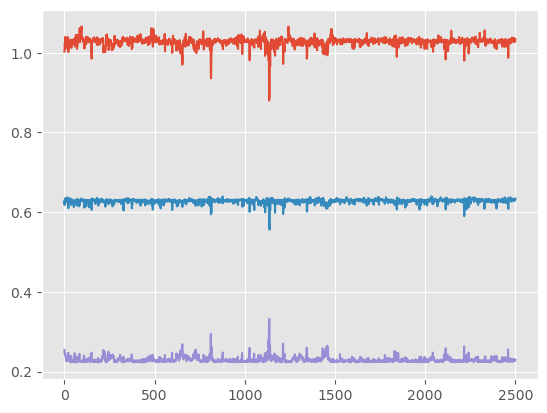

In [70]:
plt.plot(range(N-B+1), T[-3][B:])
plt.plot(range(N-B+1), T[-2][B:])
plt.plot(range(N-B+1), T[-1][B:])

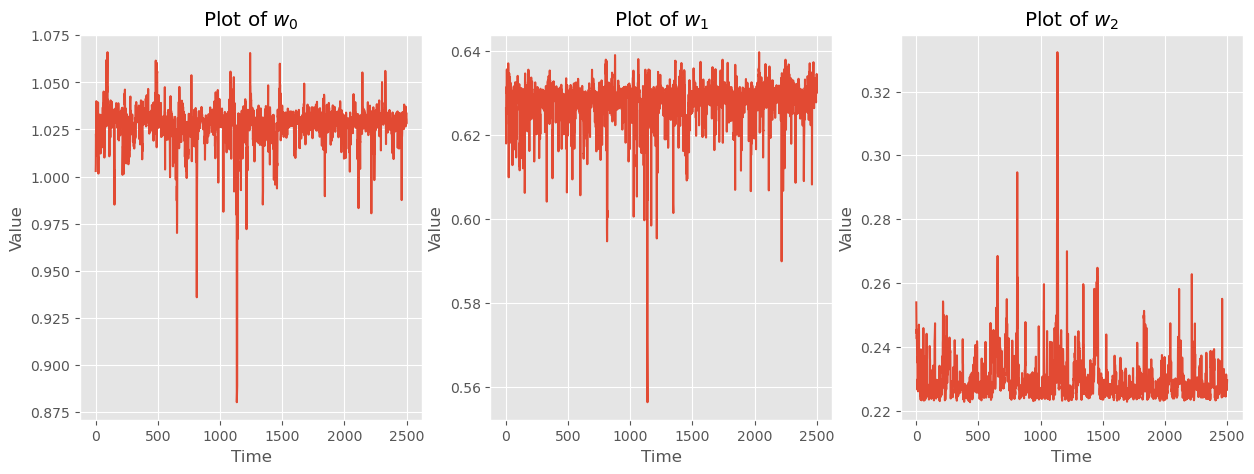

In [71]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(range(N-B+1), T[-3][B:])
axs[0].set_title('Plot of $w_{0}$')

axs[1].plot(range(N-B+1), T[-2][B:])
axs[1].set_title('Plot of $w_{1}$')

axs[2].plot(range(N-B+1), T[-1][B:])
axs[2].set_title('Plot of $w_{2}$')

for ax in axs:
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")

plt.show()

In [74]:
print(f"for w0 The acceptance rate is :{T[2][0]}  The empirical mean is : {T[0][0]} The empirical variance is : {T[1][0]}" )
print(f"for w1 The acceptance rate is :{T[2][1]}  The empirical mean is : {T[0][1]} The empirical variance is : {T[1][1]}" )
print(f"for w2 The acceptance rate is :{T[2][2]}  The empirical mean is : {T[0][2]} The empirical variance is : {T[1][2]}" )

for w0 The acceptance rate is :0.658  The empirical mean is : 1.0274724308136745 The empirical variance is : 0.00012197711019656943
for w1 The acceptance rate is :0.6976666666666667  The empirical mean is : 0.6281209359856671 The empirical variance is : 3.189970176653567e-05
for w2 The acceptance rate is :0.5636666666666666  The empirical mean is : 0.22973489111560094 The empirical variance is : 6.065502901626135e-05


### Comparaison with Q1

In [73]:
print(f"the empirical variance for w0 after using control variates is {U[1][0] / T[1][0]} smaller")
print(f"the empirical variance for w1 after using control variates is {U[1][1] / T[1][1]} smaller")
print(f"the empirical variance for w2 after using control variates is {U[1][2] / T[1][2]} smaller")

the empirical variance for w0 after using control variates is 119.4417186528269 smaller
the empirical variance for w1 after using control variates is 141.104775722254 smaller
the empirical variance for w2 after using control variates is 34.32545672239724 smaller


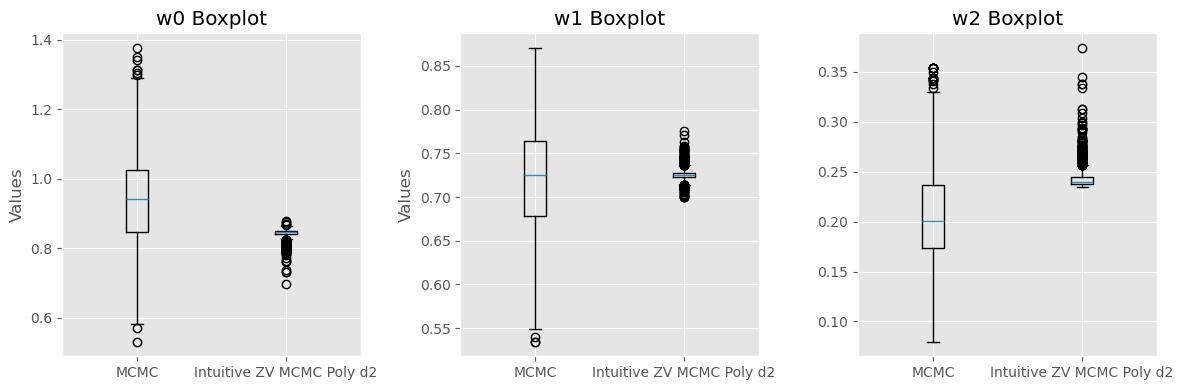

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# w_0 box-plot
axes[0].boxplot([U[-3][B:], T[-3][B:]])
axes[0].set_xticklabels(['MCMC', 'Intuitive ZV MCMC Poly d2'])
axes[0].set_ylabel('Values')
axes[0].set_title('w0 Boxplot')

# w_1 box-plot
axes[1].boxplot([U[-2][B:], T[-2][B:]])
axes[1].set_xticklabels(['MCMC', 'Intuitive ZV MCMC Poly d2'])
axes[1].set_ylabel('Values')
axes[1].set_title('w1 Boxplot')

# w_2 box-plot
axes[2].boxplot([U[-1][B:], T[-1][B:]])
axes[2].set_xticklabels(['MCMC', 'Intuitive ZV MCMC Poly d2'])
axes[2].set_title('w2 Boxplot')

fig.tight_layout()
plt.show()

We obtain better results than the ones we had on question 2, which was expected since this method can only give the same or better results as we consider the triplet ($z_0,z_1,z_2$) in all the triplets we test. 

We obtain worse results than the ones on Antonietta Mira's paper, which was also expected since she seems to have not selected control variates, and ran a "big" OLS regression with all of them.

# QUESTION 4

The fact that we do OLS regressions on MCMC samples is not completely valid since they are not independent, as every new value of the Markov chain depends on the one before.

One simple solution to "de-correlate" the samples is to average the samples over blocks of a size h such that the autocorrelation function of the MCMC sample is equal to zero in h.

Let's plot the autocorrelations of our estimators 

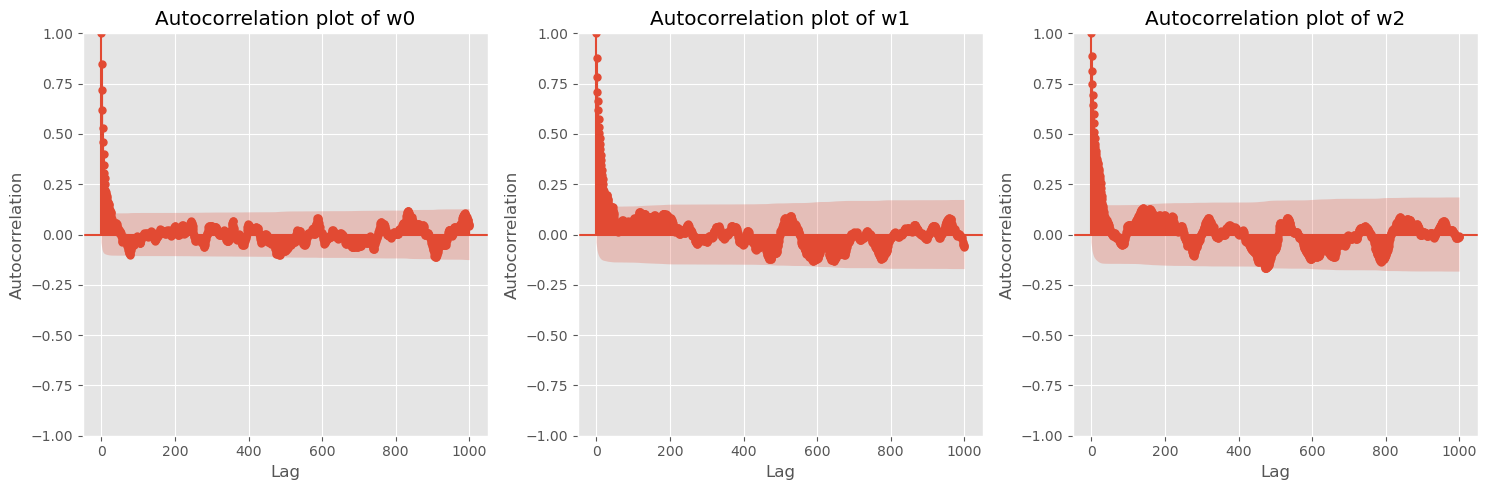

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Autocorrelation function plot for parameters w0, w1 and w2 
plot_acf(U[-3][B:], ax=axs[0], lags=1000)
axs[0].set_title("Autocorrelation plot of w0")
plot_acf(U[-2][B:], ax=axs[1], lags=1000)
axs[1].set_title("Autocorrelation plot of w1")
plot_acf(U[-1][B:], ax=axs[2], lags=1000)
axs[2].set_title("Autocorrelation plot of w2")

for ax in axs:
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")
    ax.grid(True)

# display
plt.tight_layout()
plt.show()

Here, we could choose h = 50